# TensorFlow - Style Transfer

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL.Image

### VGG-16 Model

Original research paper on style transfer used the VGG-19 CNN, but instead we will be using the VGG-16 model in a wrapper class. 

In [2]:
import vgg16

In [3]:
vgg16.maybe_download()

Data has apparently already been downloaded and unpacked.


In [4]:
def load_image(filename, max_size=None):
    image = PIL.Image.open(filename)
    if max_size is not None:
        # Calculate rescale factor to keep proportion of height and width
        factor = max_size / np.max(image.size)
    
        # Scale the image height and width
        size = np.array(image.size) * factor
        
        # size is now floating point -> cast as int for PIL
        size = size.astype(int)
        
        # Resize image
        image = image.resize(size, PIL.Image.LANCZOS)
        
    return np.float32(image)

In [5]:
def save_image(image, filename):
    # Ensure pixel values between 0 and 255
    image = np.clip(image, 0.0, 255.0)
    
    # convert to byte format
    image = image.astype(np.uint8)
    
    # Write the image-file in jpeg format
    with open(filename, 'wb') as file:
        PIL.Image.fromarray(image).save(file, 'jpeg')

In [6]:
def plot_image_big(image):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)

    # Convert pixels to bytes.
    image = image.astype(np.uint8)

    # Convert to a PIL-image and display it.
    display(PIL.Image.fromarray(image))

In [7]:
def plot_images(content_image, style_image, mixed_image):
    # Create figure with sub-plots
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))
    
    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    
    # Use interpolation to smooth pixels
    smooth = True
    
    # Interpolation type
    if smooth:
        interpolation = 'sinc'
    else:
        interpolation = 'nearest'
    
    # Plot the content-image
    # pixel values are normailized to 0 to 1.0 range
    ax = axes.flat[0]
    ax.imshow(content_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Content")
    
    # plot mixed image
    ax = axes.flat[1]
    ax.imshow(mixed_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Mixed")
    
    # Plot the style-image
    ax = axes.flat[2]
    ax.imshow(style_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Style")
    
    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

### Loss Functions

In [8]:
def mean_squared_error(a, b):
    return tf.reduce_mean(tf.square(a - b))

This loss function is applied to the feature activations between the content-image and the style-image. Our goal is to minimize the difference (loss) between the two images with respect to the feature activations.

In [9]:
def create_content_loss(session, model, content_image, layer_ids):
    '''
    Create the loss-function for the content-image
    
    Parameters:
    session: An open TensorFlow session for running the model's graph.
    model: the model which is an instance of the VGG16-class
    content_iamge: Numpy float array with the content-image.
    layer_ids: List of integer id's for the layers to use in the model.
    '''
    # create a feed-dict with the content-image.
    feed_dict = model.create_feed_dict(image=content_image)
    
    # get references to the tensors for the given layers
    layers = model.get_layer_tensors(layer_ids)
    
    # Calculate the output values of those layers when
    # feeding the content-image to the model.
    values = session.run(layers, feed_dict=feed_dict)
    
    # set the model's graph as the default
    # add computational nodes
    # might be necessary to extend this implementation
    with model.graph.as_default():
        # initialize an empty list of loss-functions.
        layer_losses = []
        
        # for each layer and its corresponding values
        # for the content-image
        for value, layer in zip(values, layers):
            # these are the values that are calculated
            # for this layer in the model when inputting the content-image
            # wrap it to make sure it is a const
            value_const = tf.constant(value)
            
            #the loss function for this layer is MSE
            # MSE between layer values when inputting content and mixed images
            # the mixed image is not calculated yet
            #creating the operations for calculating MSE between the two
            loss = mean_squared_error(layer, value_const)
            
            # Add the loss-function for this layer to list of loss-functions
            layer_losses.append(loss)
        
        # The combined loss for all layers is average
        # the loss functions could be weighted differently
        # with this implemenetation they are weighted equally (could change)
        total_loss = tf.reduce_mean(layer_losses)
    
    return total_loss

Similar process for style-layers, but now we want to measure which features in the style-layers activate concurrently for the style-image, then use this activation pattern for the mixed-image.

We can calculate the Gram-matrix for the tensors output by the style-layers. The Gram matrix is a matrix of dot-products for the vectors of the feature activations layer of style-layer.

If an entry in the Gram-matrix has a value close to zero, then it means the two features in the given layer do not activate simultaneously for the givern style image. If an entry is large, then the two features do activate simultaneously for a given style image. Then we will try to create a mixed image to replicate this activation pattern in the style-image. 

Below is a helper function for calculating the Gram-matrix of a tensor output by a convolutional layer in the neural network. The actual loss function is created further below.

In [10]:
def gram_matrix(tensor):
    shape = tensor.get_shape()
    
    # Get the number of feature channels for the input tensor.
    # which is assumed to be from a convolutional layer with 4-dim
    num_channels = int(shape[3])
    
    # Reshape the tensor so it is a 2-dim matrix. This essentially
    # flattens the contents of each feature-channel.
    matrix = tf.reshape(tensor, shape=[-1, num_channels])
    
    # Calculate the Gram-matrix as the matrix product of
    # the 2-dim matrix with itself.
    # This calculates the dot-products of all combinations of the feature channels
    gram = tf.matmul(tf.transpose(matrix), matrix)
    
    return gram

The next function (below) creates the loss-function for the style-image. It is similar to create_content_loss(), but we calculate the MSE for the **Gram-matrices** instead of the raw tensor outputs from the layers.

In [11]:
def create_style_loss(session, model, style_image, layer_ids):
    """
    Create the loss-function for the style-image.
    
    Parameters:
    session: An open TensorFlow session for running the model's graph.
    model: The model, e.g. an instance of the VGG16-class.
    style_image: Numpy float array with the style-image.
    layer_ids: List of integer id's for the layers to use in the model.
    """

    # Create a feed-dict with the style-image.
    feed_dict = model.create_feed_dict(image=style_image)

    # Get references to the tensors for the given layers.
    layers = model.get_layer_tensors(layer_ids)

    # Set the model's graph as the default so we can add
    # computational nodes to it. It is not always clear
    # when this is necessary in TensorFlow, but if you
    # want to re-use this code then it may be necessary.
    with model.graph.as_default():
        # Construct the TensorFlow-operations for calculating
        # the Gram-matrices for each of the layers.
        gram_layers = [gram_matrix(layer) for layer in layers]

        # Calculate the values of those Gram-matrices when
        # feeding the style-image to the model.
        values = session.run(gram_layers, feed_dict=feed_dict)

        # Initialize an empty list of loss-functions.
        layer_losses = []
    
        # For each Gram-matrix layer and its corresponding values.
        for value, gram_layer in zip(values, gram_layers):
            # These are the Gram-matrix values that are calculated
            # for this layer in the model when inputting the
            # style-image. Wrap it to ensure it is a const,
            # although this may be done automatically by TensorFlow.
            value_const = tf.constant(value)

            # The loss-function for this layer is the
            # Mean Squared Error between the Gram-matrix values
            # for the content- and mixed-images.
            # Note that the mixed-image is not calculated
            # yet, we are merely creating the operations
            # for calculating the MSE between those two.
            loss = mean_squared_error(gram_layer, value_const)

            # Add the loss-function for this layer to the
            # list of loss-functions.
            layer_losses.append(loss)

        # The combined loss for all layers is just the average.
        # The loss-functions could be weighted differently for
        # each layer. You can try it and see what happens.
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

In [12]:
def  create_denoise_loss(model):
    loss = tf.reduce_sum(tf.abs(model.input[:,1:,:,:] - model.input[:,:-1,:,:])) + \
           tf.reduce_sum(tf.abs(model.input[:,:,1:,:] - model.input[:,:,:-1,:]))

    return loss

### Style Transfer Algorithm

In [13]:
def style_transfer(content_image, style_image,
                   content_layer_ids, style_layer_ids,
                   weight_content=1.5, weight_style=10.0,
                   weight_denoise=0.3,
                   num_iterations=120, step_size=10.0):
    '''
    Use gradient descent to find an image that minimizes the loss-functions of the content-layers and style-layers.
    This should result in a mixed-image the resembles the contours of the content-image, and resembles the colours and textures
    of the style-image.
    
    Parameters:
    content_image: Numpy 3-dim float-array with the content-image.
    style_image: Numpy 3-dim float-array with the style-image.
    content_layer_ids: list of integers identifying the content-layers.
    style_layer_ids: List of integers identifying the style_layers
    weight_content: Weight for the content-loss-function.
    weight_style: weight for the style-loss-function
    weight_denoise: weight for the denoising-loss-function
    num_iterations: number of optimization iterations to perform
    step_size: step-size for the gradient descent each iteration
    '''
    # Create instance of VGG16 model
    # done each call of the function
    # run out of RAM if keep using same instance..
    model = vgg16.VGG16()
    
    session = tf.InteractiveSession(graph=model.graph)
    
    print("Content layers:")
    print(model.get_layer_names(content_layer_ids))
    print()
    
    print("Style layers:")
    print(model.get_layer_names(style_layer_ids))
    print()
    
    loss_content = create_content_loss(session=session,
                                       model=model, 
                                       content_image=content_image,
                                       layer_ids=content_layer_ids)
    
    loss_style = create_style_loss(session=session,
                                   model=model,
                                   style_image=style_image,
                                   layer_ids=style_layer_ids)
    
    loss_denoise = create_denoise_loss(model)
    
    adj_content = tf.Variable(1e-10, name='adj_content')
    adj_style = tf.Variable(1e-10, name='adj_style')
    adj_denoise = tf.Variable(1e-10, name='adj_denoise') 
    
    session.run([adj_content.initializer,
                 adj_style.initializer,
                 adj_denoise.initializer])
    
    # Create TensorFlow operations for updating the adjustment values.
    # reciprocal values of the loss-functions
    # the 1e-10 is to avoid zero division error
    update_adj_content = adj_content.assign(1.0 / (loss_content + 1e-10))
    update_adj_style = adj_style.assign(1.0 / (loss_style + 1e-10))
    update_adj_denoise = adj_denoise.assign(1.0 / (loss_denoise + 1e-10))
    
    # This is the weighted loss function to minimize
    # to generate the mixed-image
    # multiply the loss-values with their reciprocal adj values
    # use relative weights for the loss-functions 
    # independent of exact choice of style and content-layers
    loss_combined = weight_content * adj_content * loss_content + \
                    weight_style * adj_content * loss_style + \
                    weight_denoise * adj_denoise * loss_denoise
    
    # TensorFlow to get the mathematical gradient function
    # gradient of the combined loss for the input image
    gradient = tf.gradients(loss_combined, model.input)
    
    # list of tensors that we will run in each optimization iteration
    run_list = [gradient, update_adj_content, update_adj_style, \
                update_adj_denoise]
    
    # The mixed-image is initialized with random noise.
    # It is the same size as content-image.
    mixed_image = np.random.rand(*content_image.shape) + 128
    
    for i in range(num_iterations):
        # create a feed-dict with the mixed image
        feed_dict = model.create_feed_dict(image=mixed_image)
        
        # Use tensorflow to calculate gradient value
        # update adjustment values.
        grad, adj_content_val, adj_style_val, adj_denoise_val \
        = session.run(run_list, feed_dict=feed_dict)
        
        # Reduce the dimensionality of the gradient.
        grad = np.squeeze(grad)
        
        # Scale the step-size according to the gradient-values.
        step_size_scaled = step_size / (np.std(grad) + 1e-8)
        
        # Update the image by the following gradient.
        mixed_image -= grad * step_size_scaled
        
        # Ensure the image has valid pixel values
        mixed_image = np.clip(mixed_image, 0.0, 255.0)
        
        # Progress indicator
        print(". ", end="")
        
        # Display status once every 10 iterations and the last.
        if (i % 10 == 0) or (i == num_iterations - 1):
            print()
            print("Iteration:", i)
            
            msg = "Weight Adj. for Content: {0:.2e}, Style: {1:.2e}, Denoise: {2:.2e}"
            print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))
            
            # Plot the content-, style- and mixed images
            plot_images(content_image=content_image,
                        style_image=style_image,
                        mixed_image=mixed_image)
            
    print()
    print("Final image:")
    plot_image_big(mixed_image)
    
    # Close the Tensorflow session to release its resources
    session.close()
    return mixed_image

### Example Use

In [14]:
content_filename = 'images/willy_wonka_old.jpg'
content_image = load_image(content_filename, max_size=None)

In [15]:
style_filename = 'images/style7.jpg'
style_image = load_image(style_filename, max_size=300)

In [16]:
# VGG16-Model has 13 convolutional layers.
# Selects all th elayers as style layers
# slow to optimize
content_layer_ids = [4]
style_layer_ids = list(range(13))

Content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']

. 
Iteration: 0
Weight Adj. for Content: 5.18e-11, Style: 2.14e-29, Denoise: 5.61e-06


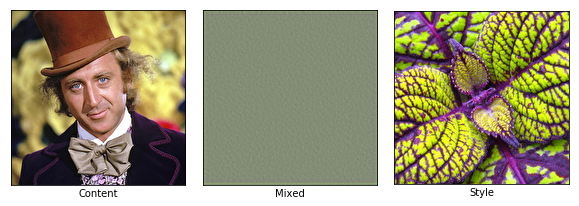

. . . . . . . . . . 
Iteration: 10
Weight Adj. for Content: 1.88e-11, Style: 4.03e-28, Denoise: 1.38e-07


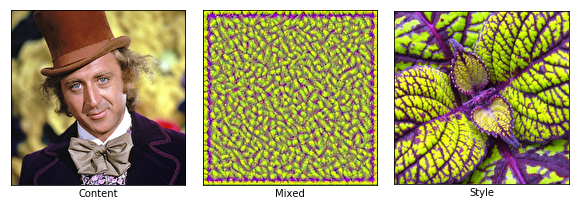

. . . . . . . . . . 
Iteration: 20
Weight Adj. for Content: 1.87e-11, Style: 4.46e-28, Denoise: 1.35e-07


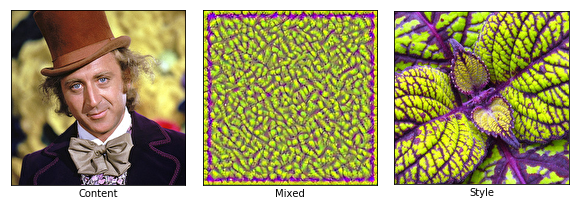

. . . . . . . . . . 
Iteration: 30
Weight Adj. for Content: 1.84e-11, Style: 4.97e-28, Denoise: 1.31e-07


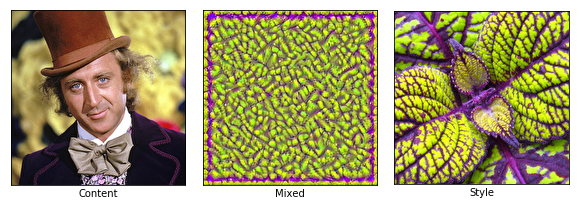

. . . . . . . . . . 
Iteration: 40
Weight Adj. for Content: 1.82e-11, Style: 5.62e-28, Denoise: 1.27e-07


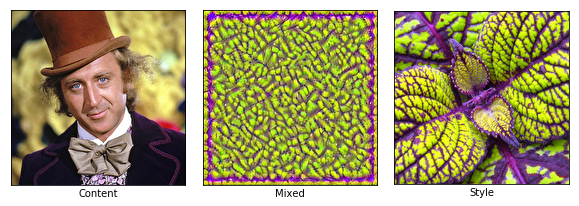

. . . . . . . . . . 
Iteration: 50
Weight Adj. for Content: 1.64e-11, Style: 1.40e-27, Denoise: 1.16e-07


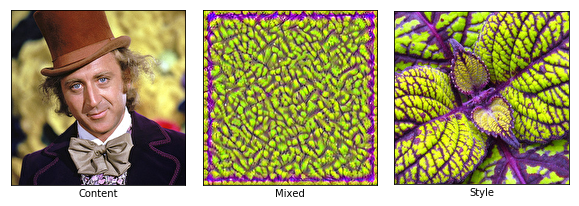

. . . . . . . . . . 
Iteration: 60
Weight Adj. for Content: 1.64e-11, Style: 1.86e-27, Denoise: 1.12e-07


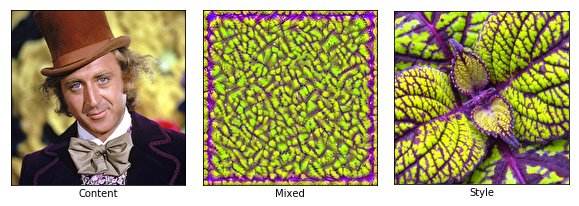

. . . . . . . . . . 
Iteration: 70
Weight Adj. for Content: 1.69e-11, Style: 1.22e-27, Denoise: 1.13e-07


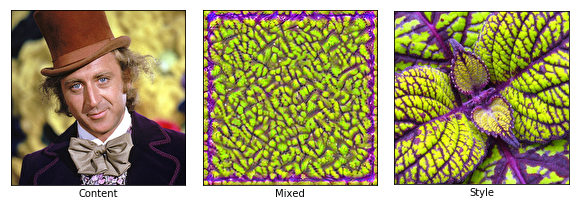

. . . . . . . . . . 
Iteration: 80
Weight Adj. for Content: 1.66e-11, Style: 1.66e-27, Denoise: 1.08e-07


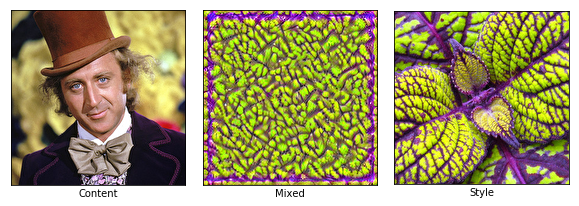

. . . . . . . . . . 
Iteration: 90
Weight Adj. for Content: 1.67e-11, Style: 1.66e-27, Denoise: 1.05e-07


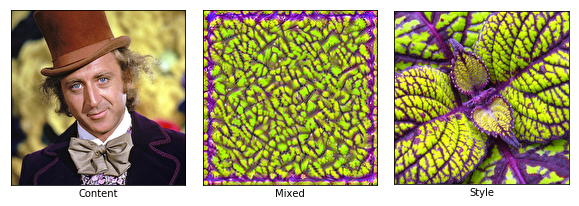

. . . . . . . . . . 
Iteration: 100
Weight Adj. for Content: 1.68e-11, Style: 1.55e-27, Denoise: 1.03e-07


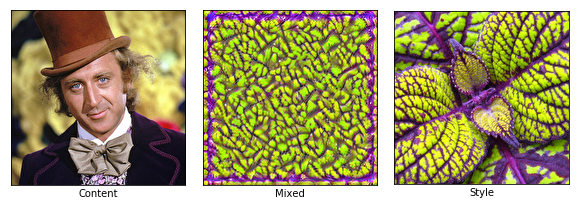

. . . . . . . . . . 
Iteration: 110
Weight Adj. for Content: 1.68e-11, Style: 1.46e-27, Denoise: 1.02e-07


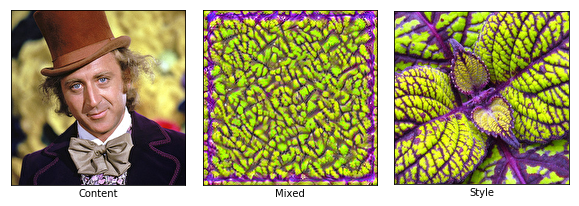

. . . . . . . . . . 
Iteration: 120
Weight Adj. for Content: 1.69e-11, Style: 1.38e-27, Denoise: 1.00e-07


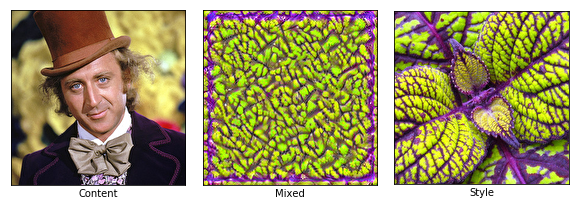

. . . . . . . . . . 
Iteration: 130
Weight Adj. for Content: 1.69e-11, Style: 1.34e-27, Denoise: 9.93e-08


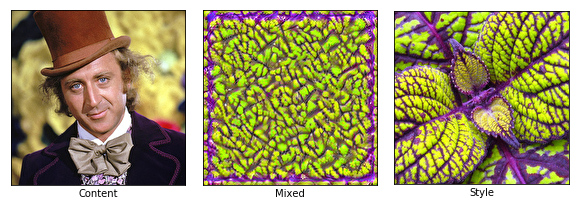

. . . . . . . . . . 
Iteration: 140
Weight Adj. for Content: 1.70e-11, Style: 1.32e-27, Denoise: 9.80e-08


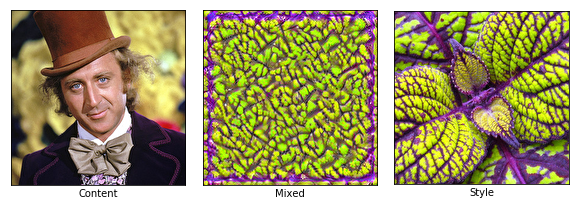

. . . . . . . . . . 
Iteration: 150
Weight Adj. for Content: 1.69e-11, Style: 1.32e-27, Denoise: 9.67e-08


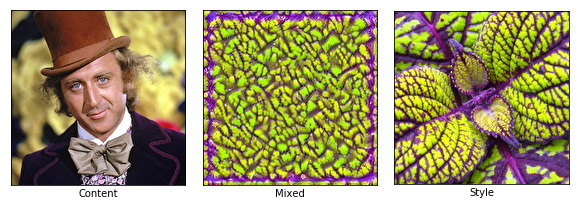

. . . . . . . . . . 
Iteration: 160
Weight Adj. for Content: 1.70e-11, Style: 1.32e-27, Denoise: 9.55e-08


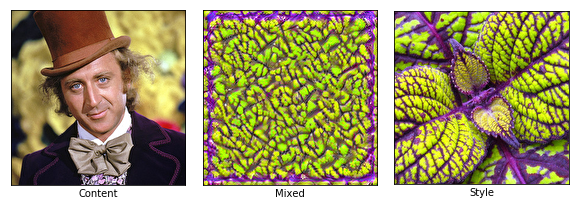

. . . . . . . . . . 
Iteration: 170
Weight Adj. for Content: 1.69e-11, Style: 1.40e-27, Denoise: 9.43e-08


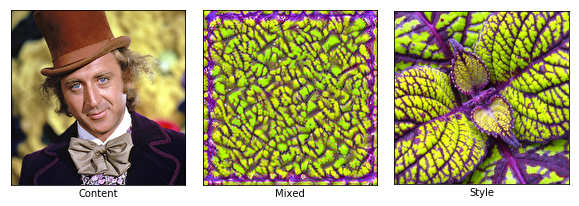

. . . . . . . . . . 
Iteration: 180
Weight Adj. for Content: 1.69e-11, Style: 1.40e-27, Denoise: 9.31e-08


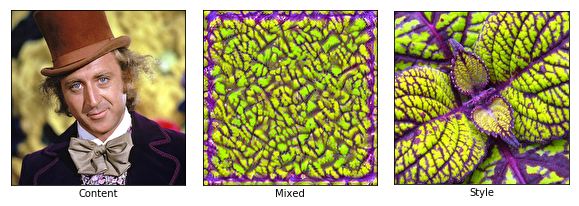

. . . . . . . . . . 
Iteration: 190
Weight Adj. for Content: 1.69e-11, Style: 1.37e-27, Denoise: 9.20e-08


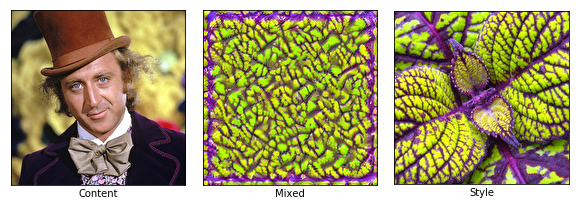

. . . . . . 

In [ ]:
%%time
img = style_transfer(content_image=content_image,
                     style_image=style_image,
                     content_layer_ids=content_layer_ids,
                     style_layer_ids=style_layer_ids,
                     weight_content=1.5,
                     weight_style=10.0,
                     weight_denoise=0.3,
                     num_iterations=600,
                     step_size=10.0)

Part of a series of TensorFlow tutorials developed by Hvass Laboratories. Copyright (c) 2016 by Magnus Erik Hvass Pedersen